In [250]:
import pvl
import struct
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
import binascii


In [251]:
mimap_file = '/Users/gnelson/temp/merData/case01/input/1M189529263EFF64KCP2977M2F1.IMG'
image_file = mimap_file

In [252]:
header = pvl.load(mimap_file)
header

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 2048)
  ('FILE_RECORDS', 1043)
  ('LABEL_RECORDS', 12)
  ('^IMAGE_HEADER', 13)
  ('^IMAGE', 20)
  ('DATA_SET_ID', 'MER1-M-MI-2-EDR-SCI-V1.0')
  ('DATA_SET_NAME', 'MER 1 MARS MICROSCOPIC IMAGER SCIENCE EDR VERSION 1.0')
  ('COMMAND_SEQUENCE_NUMBER', 1)
  ('FRAME_ID', 'MONO')
  ('FRAME_TYPE', 'MONO')
  ('GEOMETRY_PROJECTION_TYPE', 'RAW')
  ('IMAGE_ID', 129770201)
  ('IMAGE_TYPE', 'REGULAR')
  ('INSTRUMENT_HOST_ID', 'MER1')
  ('INSTRUMENT_HOST_NAME', 'MARS EXPLORATION ROVER 1')
  ('INSTRUMENT_ID', 'MI')
  ('INSTRUMENT_NAME', 'MICROSCOPIC IMAGER')
  ('INSTRUMENT_SERIAL_NUMBER', 110)
  ('INSTRUMENT_TYPE', 'IMAGING CAMERA')
  ('INSTRUMENT_VERSION_ID', 'FM')
  ('LOCAL_TRUE_SOLAR_TIME',
   datetime.time(12, 7, 38, tzinfo=datetime.timezone.utc))
  ('MAGNET_ID', 'NULL')
  ('MISSION_NAME', 'MARS EXPLORATION ROVER')
  ('MISSION_PHASE_NAME', 'PRIMARY MISSION')
  ('OBSERVATION_ID', 3204473856)
  ('PLANET_DA

In [253]:
with open(mimap_file, 'rb') as f:
    image_offset = ((header["^IMAGE"] -1) * (header["RECORD_BYTES"])) -1
    f.seek(image_offset)
    b_image_data = f.read()

print(b_image_data[0:20], image_offset)


b'\x00\x062\x02\x8f\x02j\x02F\x02.\x01\xc9\x01\xde\x02\x00\x01\xaa\x01' 38911


In [254]:
n_lines = 4
n_samples = 5
line_length = header['IMAGE']['LINE_SAMPLES'] * (header['IMAGE']['SAMPLE_BITS']//8)

In [255]:
image_data = []
line_offset = 100
sample_offset = 100

for j in range(line_offset, n_lines * header['IMAGE']['BANDS'] + line_offset + 1):
    print(j*line_length,(j+1)*line_length)
    image_sample = np.frombuffer(b_image_data[j*line_length:(j+1)*line_length], dtype=np.int16, count=int(line_length/2))
    image_data.append(image_sample)
image_data = np.array(image_data)
image_data = image_data[:, sample_offset:sample_offset + n_samples]
print(image_data.shape)

204800 206848
206848 208896
208896 210944
210944 212992
212992 215040
(5, 5)


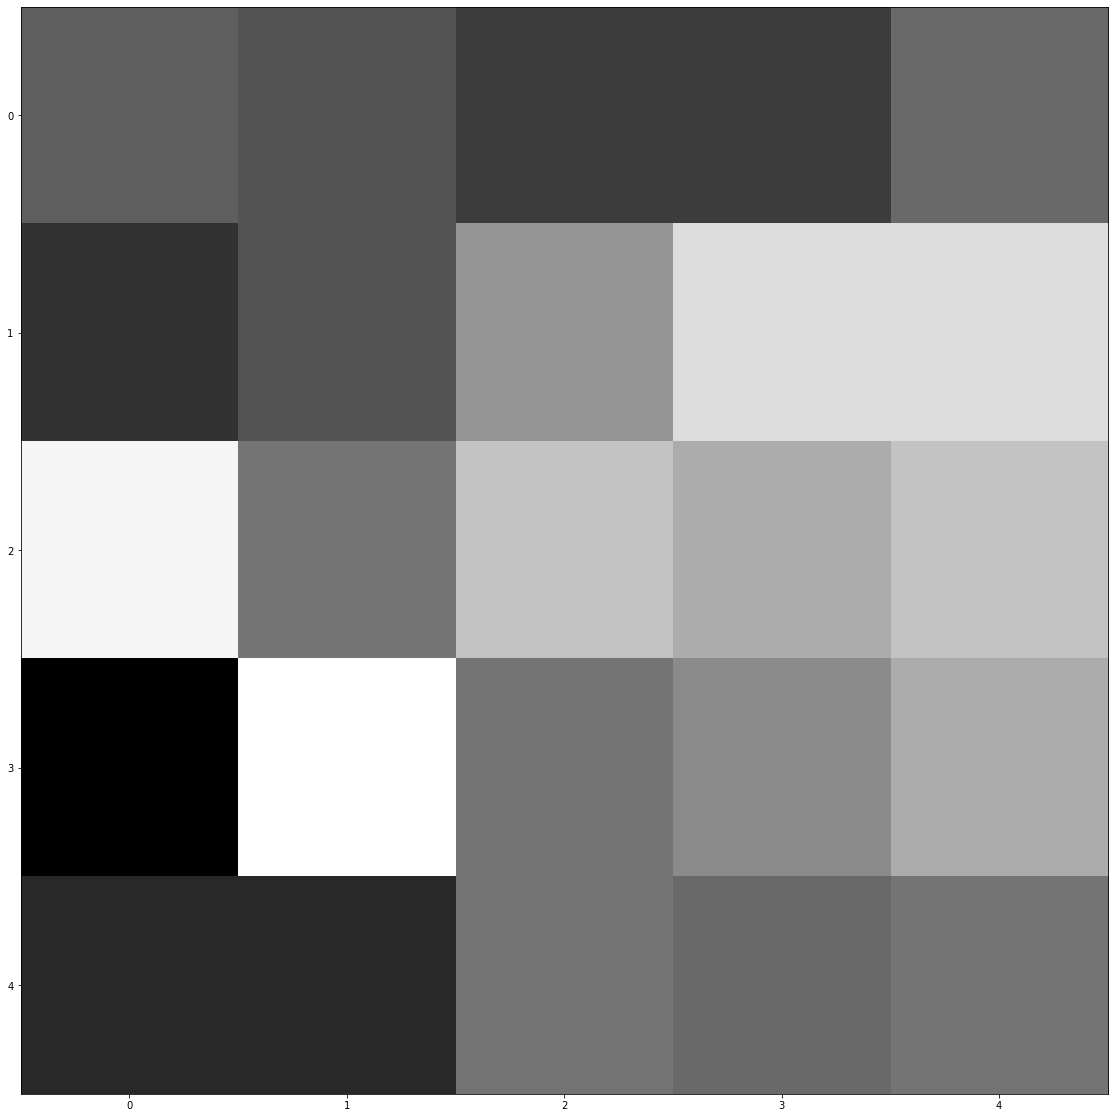

In [256]:
plt.figure(figsize=(20,20))
plt.imshow(image_data,cmap="gray")#[0:20,0:20])

In [257]:
print(image_data[0][0])


class RealIsisCubeLabelEncoder(pvl.encoder.ISISEncoder):
    def encode_time(self, value):
        if value.microsecond:
            second = u'%02d.%06d' % (value.second, value.microsecond)
        else:
            second = u'%02d' % value.second
            time = u'%02d:%02d:%s' % (value.hour, value.minute, second)
        return time



570


In [258]:
import math

image_fn, image_ext = os.path.splitext(image_file)
crop = '_cropped'
mini_image_fn = image_fn + crop + image_ext
print(mini_image_fn)
mini_image_bn = os.path.basename(mini_image_fn)
grammar = pvl.grammar.ISISGrammar()
grammar.comments+=(("#", "\n"), )
encoder = RealIsisCubeLabelEncoder()
# Overwrite the number of lines in the label
header['IMAGE']['LINES'] = n_lines + 1
header['IMAGE']['LINE_SAMPLES'] = n_samples
actual_label_size = len(pvl.dumps(header, encoder=encoder, grammar=grammar)) / header["RECORD_BYTES"]
print(actual_label_size)
header['^IMAGE'] = math.ceil(actual_label_size) + 1
print(int(header["RECORD_BYTES"] * (math.ceil(actual_label_size) - actual_label_size)))
# - 1 from 0 based and another - 1 from the new line written before the padding
padding = ['0' for i in range(0, (int(header["RECORD_BYTES"] * (math.ceil(actual_label_size) - actual_label_size))) - 1)]
padding = ''.join(padding)
padding = padding.encode('utf8')
print(padding)

/Users/gnelson/temp/merData/case01/input/1M189529263EFF64KCP2977M2F1_cropped.IMG
8.8232421875
362
b'0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000'


In [259]:
label_fn, label_ext = os.path.splitext(mimap_file)
out_label = label_fn + crop + label_ext

pvl.dump(header, out_label, encoder=encoder, grammar=grammar)


18070

In [260]:
with open(mini_image_fn, 'ab+') as f:
    b_reduced_image_data = image_data.tobytes()
    f.write(b'\n')
    f.seek(0, 2)
    f.write(padding)
    f.write(b_reduced_image_data)
print(len(b_reduced_image_data),len(padding))

50 361


In [261]:
pvl.load(mini_image_fn)

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 2048)
  ('FILE_RECORDS', 1043)
  ('LABEL_RECORDS', 12)
  ('^IMAGE_HEADER', 13)
  ('^IMAGE', 10)
  ('DATA_SET_ID', 'MER1-M-MI-2-EDR-SCI-V1.0')
  ('DATA_SET_NAME', 'MER 1 MARS MICROSCOPIC IMAGER SCIENCE EDR VERSION 1.0')
  ('COMMAND_SEQUENCE_NUMBER', 1)
  ('FRAME_ID', 'MONO')
  ('FRAME_TYPE', 'MONO')
  ('GEOMETRY_PROJECTION_TYPE', 'RAW')
  ('IMAGE_ID', 129770201)
  ('IMAGE_TYPE', 'REGULAR')
  ('INSTRUMENT_HOST_ID', 'MER1')
  ('INSTRUMENT_HOST_NAME', 'MARS EXPLORATION ROVER 1')
  ('INSTRUMENT_ID', 'MI')
  ('INSTRUMENT_NAME', 'MICROSCOPIC IMAGER')
  ('INSTRUMENT_SERIAL_NUMBER', 110)
  ('INSTRUMENT_TYPE', 'IMAGING CAMERA')
  ('INSTRUMENT_VERSION_ID', 'FM')
  ('LOCAL_TRUE_SOLAR_TIME',
   datetime.time(12, 7, 38, tzinfo=datetime.timezone.utc))
  ('MAGNET_ID', None)
  ('MISSION_NAME', 'MARS EXPLORATION ROVER')
  ('MISSION_PHASE_NAME', 'PRIMARY MISSION')
  ('OBSERVATION_ID', 3204473856)
  ('PLANET_DAY_

In [262]:
with open(mini_image_fn, 'rb') as f:
  image_offset = ((header["^IMAGE"] -1) * header["RECORD_BYTES"])
  f.seek(image_offset)
  b_image_data = f.read()

In [263]:
print(image_offset,b_image_data,len(b_image_data))
image_data = np.frombuffer(b_image_data, dtype=np.int16).reshape((n_lines + 1, n_samples))
plt.figure(0, figsize=(20, 20))
plt.imshow(image_data)
plt.show()

18431 b'0:\x02.\x02\x16\x02\x16\x02F\x02\x0b\x02.\x02v\x02\xc3\x02\xc3\x02\xde\x02R\x02\xa9\x02\x8f\x02\xa9\x02\xd4\x01\xe9\x02R\x02j\x02\x8f\x02\x00\x02\x00\x02R\x02F\x02R\x02' 51


ValueError: buffer size must be a multiple of element size